In [1]:
# save files
fullproc_r = '/Users/jnaiman/LMM_Figure_Parsing/resources/' # for words/names

# extra fonts (downloaded) -- these mimic old-timey fonts
extra_font_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FullProcess_resources/fonts/' # see this dir for README for how these were installed
extra_font_search_dir = '/opt/anaconda3/envs/FullProcess/fonts/' # check env here for font to be there

# where to save the figures that are created
fake_figs_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/Paper_JCDL2025/example_hists/'

# save diagnostic plot with all items labeled?
save_diagnostic_plot = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
#import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor
import json
import os
from copy import deepcopy
import copy

from utils.metric_utils.utilities import isRectangleOverlap

import time

import matplotlib as mpl
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}' #for \text command

# written libs -- will update locally
from utils.synthetic_fig_utils import subset_by_percent, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks, get_titles_or_labels, \
 get_font_info

from utils.plot_utils import get_contour_plot, get_histogram_plot, \
   get_line_plot, get_scatter_plot, make_plot, colorbar_mods#, get_line_plot

from utils.text_utils import get_popular_nouns, get_inline_math

# create a bunch of fake figures
from utils.synthetic_fig_utils import normalize_params_prob
from utils.plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, colorbar_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base

from utils.data_utils import get_data, NumpyEncoder

import utils.distribution_utils

from utils.plot_utils import markers
marker_sizes = np.arange(0,10)+1
line_list_thick = np.arange(1,10)

use_uniques = True # use unique inlines
verbose = True

from sys import path
path.append('/Library/TeX/texbin/')

# debug
from importlib import reload

# for seed
from sys import maxsize as maxint

import warnings
warnings.filterwarnings("error")

In [3]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')

# check that location is there
drop_names = []
for fl in dfont['font location']:
    if not os.path.exists(fl):
        drop_names.append(False)
    else:
        drop_names.append(True)

font_names = dfont.loc[drop_names]['font name'].values

# # for plot styles
# plot_styles = plt.style.available

# plot_types_qa = ['line', 'scatter', 'histogram']

plot_styles = ['default']

In [4]:
# stats for doing calculations
stats = {'minimum':np.min, 'maximum':np.max, 'median':np.median, 'mean':np.mean}

# some things to try
aspect_cut = {'min':0.3, 'max':4.0}

In [5]:
# get popular words for titles/axis
popular_nouns = get_popular_nouns(fullproc_r + 'data/')

# get inline math formulas
inlines = get_inline_math(fullproc_r,
                          recreate_inlines=False,
                         use_uniques=use_uniques)

16253 343492
shape of output= (5097, 5)
shape of output= (36332, 5)
number of inlines =  33201


## Update plotting params

### Plot type params

In [6]:
plot_params = plot_types_params.copy()

In [7]:
# only histograms for this one

# probability of getting a scatter plot
plot_params['scatter']['prob'] = 0
# probability of getting a line
plot_params['line']['prob'] = 0
# prob of getting a contour plot
plot_params['contour']['prob'] = 0
# prob of getting an image of the sky
plot_params['image of the sky']['prob'] = 0

In [8]:
# prob for getting a histogram
plot_params['histogram']['prob'] = 1


linestyles_hist = ['-'] # only use a subset of the linestyles

plot_params['histogram'] = plot_params['histogram'].copy()

# no horizontal plots
plot_params['histogram']['horizontal prob'] = 0.0

# random distributions
plot_params['histogram']['distribution']['random']['prob'] = 0

# gaussian mixture model
plot_params['histogram']['distribution']['gmm']['prob'] = 1
plot_params['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 5}
plot_params['histogram']['distribution']['gmm']['nsamples'] = {'min': 10, 'max': 50}

# linear distributions prob
plot_params['histogram']['distribution']['linear']['prob'] = 1

### Other parameters

In [9]:
panel_params['number prob']['median'] = 4 # smaller, usually use 4-ish, 1 for debugging
panel_params['number prob']['max'] = 25 # 2 for debugging, 25 for typical run

In [10]:
# for ease of things, lets not do equations here
title_params['equation']['prob'] = 0.0 # probability any word will be equation
xlabel_params['equation']['prob'] = 0.0 # probability any word will be equation
ylabel_params['equation']['prob'] = 0.0 # probability any word will be equation

Renormalize all probabilities:

In [11]:
# reload for debug
import utils.synthetic_fig_utils
reload(utils)
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import normalize_params_prob

plot_params_out, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params, colorbar_params)

plot_params_out

title_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
xlabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
ylabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
colorbar_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
plot_types_params['scatter']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bottom': 0.058823529411764705}
plot_types_params['contour']['color b

{'line': {'prob': 0,
  'npoints': {'min': 10, 'max': 11},
  'line thick': {'min': 1, 'max': 5},
  'nlines': {'min': 2, 'max': 3},
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'prob same x': 0.1,
  'markers': {'prob': 0.5, 'size': {'min': 1, 'max': 20}},
  'error bars': {'elinewidth': {'min': 1, 'max': 5},
   'x': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}},
   'y': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}}},
  'distribution': {'random': {'prob': 0.3333333333333333},
   'linear': {'prob': 0.3333333333333333,
    'intersect': (-100, 100),
    'slope': (-5, 5),
    'noise': (0, 0.25)},
   'gmm': {'prob': 0.3333333333333333,
    'histogram as line': {'prob': 0.25, 'factor': 1000},
    'nclusters': {'min': 1, 'max': 20},
    'nsamples': {'min': 10, 'max': 500},
    'cluster std': {'min': -2, 'max': 0.5},
    'noise': {'min': 0.05, 'max': 0.25}}}},
 'histogram': {'prob': 1,
  'npoints': {'min': 10, 'max': 10000},
  'nbins': {'min': 1, 'max': 100},
  '

### Run the thing

In [12]:
# Set a seed if you want a reproducible thing
seed_outer = np.random.randint(maxint)
#seed_outer = 7526304181034464103
seed_outer = 6700012876856450103

print('seed_outer =',seed_outer)
rng_outer = np.random.default_rng(seed_outer)

seed_outer = 6700012876856450103


In [13]:
# "Inner" seed -- for things like distributions and whatnot
seed = np.random.randint(maxint)
#seed = 2870146871786070273
seed = 7067533564274193147
print('seed = ', seed)
# based on seed, make random number generator, see: https://numpy.org/doc/2.2/reference/random/generator.html
rng = np.random.default_rng(seed)
condition_overlap_xticklabels = True

seed =  7067533564274193147


In [14]:
# set some things to keep standard across images

tight_layout = True

color_map = 'Blues' #rng_outer.choice(plt.colormaps())

plot_style = 'default' #rng_outer.choice(plot_styles)

npanels, panel_style, nrows, ncols = 1, 'square', 1, 1 #get_nrows_and_ncols(panel_params, rng=rng_outer)

aspect_fig = 0.9

dpi =  300 # int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))

In [15]:
# use the "fixed" RNG outer
# get all font stuffs
title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                        csfont = get_font_info(fontsizes, font_names, rng=rng_outer)

In [16]:
def make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                   base=5, verbose=True, tight_layout = True):
    plt.close('all')
    plt.style.use(plot_style)
    plt.set_cmap(color_map) 
    figsize = (base*ncols*aspect_fig, base*nrows) # w,h
    if verbose: print('figsize (w,h) =', figsize)

    if tight_layout:
        fig = plt.figure(figsize=figsize, dpi=dpi,layout='tight')
    else:
        fig = plt.figure(figsize=figsize, dpi=dpi)

    axes = []
    for i in range(nrows):
        for j in range(ncols):
            iplot = (i*nrows) + j
            ax = fig.add_subplot(nrows, ncols, iplot + 1)
            axes.append(ax)


    # #### create placeholder axes -- I think this is now obsoluete and should be updated (JPN)
    # axes = np.empty((nrows,ncols),dtype='object')

    # if npanels == 1:
    #     axes = [axes]
    #     plot_inds = [(0,0)] # i,j
    # else: # flatten, for now
    #     # create inds
    #     if len(axes.shape) > 1: # 2d
    #         ashape = np.array(axes.shape).copy()
    #     else:
    #         ashape = [nrows, ncols]
    #     plot_inds = np.empty(shape=(ashape[0], ashape[1],2), dtype=int)
    #     for i in range(ashape[0]):
    #         for j in range(ashape[1]):
    #             plot_inds[i,j][0] = i
    #             plot_inds[i,j][1] = j
    #     plot_inds = plot_inds.reshape((ashape[0]*ashape[1],-1))
    #     axes = axes.flatten()
    return fig, axes #, axes, plot_inds

In [17]:
choices = []; probs = []
for k,v in plot_params_out.items():
    choices.append(k)
    probs.append(v['prob'])

plot_type = rng.choice(choices, p=probs)
plot_type

np.str_('histogram')

In [18]:
# def try_something(var1, **kwargs):
#     for k,v in kwargs.items():
#         if 'var1' in k:
#             var1 = v

#     print('var1 is:', var1)

In [19]:
#try_something(var1 = 'bob')

In [20]:
# #setattr(someobject, key, value)
# # setattr(var2, 3.0)

# class Histogram():
#     def __init__(self):
#         self.rwidth = None
#         self.elinewidth = None

# hist = Histogram()

In [21]:
# for k,v in hist.__dict__.items():
#     print(k,v)

In [22]:
distribution_type = 'gmm'
xmin, xmax = -1, 1 # for now

# now specific for *this plot*
plot_params_here = plot_params_out.copy()

plot_params_here['histogram']['xmin'] = xmin
plot_params_here['histogram']['xmax'] = xmax

plot_params_here['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 1}
plot_params_here['histogram']['distribution']['gmm']['nsamples'] = {'min': 10000, 'max': 10000}
#plot_params_here['histogram']['distribution']['gmm']['xmin'] = xmin # are these even used??
#plot_params_here['histogram']['distribution']['gmm']['xmax'] = xmax # are these even used??

dist_params = plot_params_here[plot_type]['distribution'] 

In [31]:
dist_params

{'random': {'prob': 0.0},
 'linear': {'prob': 0.5,
  'intersect': (-100, 100),
  'slope': (-5, 5),
  'noise': (0, 0.25)},
 'gmm': {'prob': 0.5,
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'nclusters': {'min': 5, 'max': 5},
  'nsamples': {'min': 10000, 'max': 10000},
  'cluster std': {'min': -1, 'max': 1.5},
  'noise': {'min': 0.05, 'max': 0.25}}}

In [23]:
import utils.distribution_utils
reload(utils.distribution_utils)

data_for_plot = get_data(plot_params_here[plot_type],
                plot_type=plot_type,
                        distribution=distribution_type, 
                        rng=rng)
data_for_plot

{'xs': array([0.82055095, 0.82375684, 0.82172528, ..., 0.86056228, 0.87080305,
        0.83310381]),
 'ys': [],
 'xerrs': True,
 'data params': {'nsamples': 10000,
  'nclusters': 1,
  'centers': array([[0.85855147]]),
  'cluster_std': array([0.14265167]),
  'noise level': 0.1049343528642392}}

figsize (w,h) = (1.8, 2)


<Figure size 640x480 with 0 Axes>

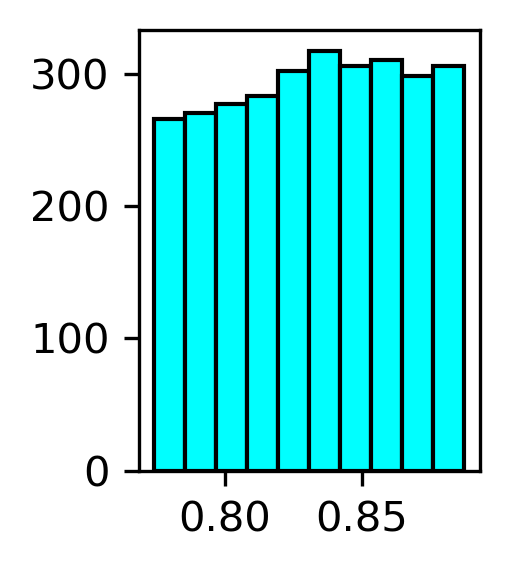

In [24]:
import utils.plot_utils
reload(utils.plot_utils)
from utils.plot_utils import make_plot

fig, axes = make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                   base=2, verbose=True, tight_layout = tight_layout)

data_from_plot, ax = make_plot(plot_params_here[plot_type], data_for_plot, 
                        axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                        rng=rng, 
                        barcolor='cyan', linecolor=(0,0,0), hasErr = False, lthick=1, nbins=10, rwidth=1.0)

In [25]:
data_from_plot

{'data': (array([266., 270., 277., 283., 302., 317., 306., 310., 298., 306.]),
  array([0.77411229, 0.78546148, 0.79681067, 0.80815986, 0.81950905,
         0.83085824, 0.84220744, 0.85355663, 0.86490582, 0.87625501,
         0.8876042 ]),
  <BarContainer object of 10 artists>),
 'plot params': {'linethick': 1,
  'linestyles': np.str_('-'),
  'bar color': 'cyan',
  'edge color': [array([0, 0, 0])],
  'orientation': 'vertical',
  'rwidth': 1.0,
  'nbins': 10}}

In [26]:
data_for_plot

{'xs': array([0.82055095, 0.82375684, 0.82172528, ..., 0.86056228, 0.87080305,
        0.83310381]),
 'ys': [],
 'xerrs': True,
 'data params': {'nsamples': 10000,
  'nclusters': 1,
  'centers': array([[0.85855147]]),
  'cluster_std': array([0.14265167]),
  'noise level': 0.1049343528642392}}

Loop for several distributions and save:

In [27]:
from utils.histogram_plot_qa_utils import q_nbars_hist_plot_plotnums, q_colors_hist_plot_plotnums, \
  q_colorlines_hist_plot_plotnums, q_linethickness_hists, q_barpoints_bars, q_stats_hists, \
  q_errorbars_existance_lines, q_errorbars_size_histogram, q_distribution_hists, \
  q_linear_equation_hists, q_gmm_equation_hists

In [35]:
#plot_params_loop['histogram']['distribution']['gmm']

figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)


<Figure size 640x480 with 0 Axes>

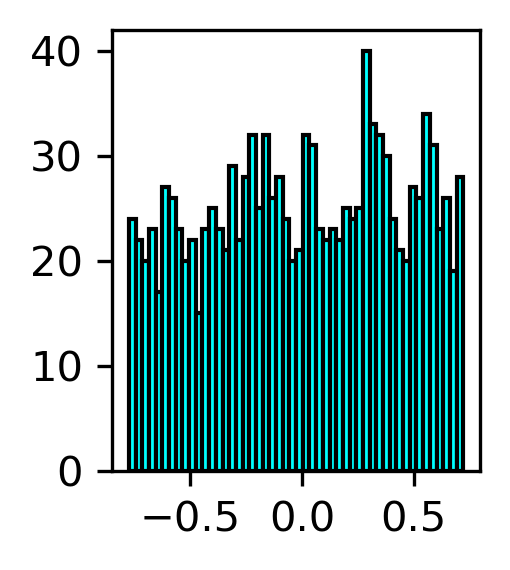

In [36]:
nclusters = [1, 2, 3, 4, 5]

cluster_std = {'min':0.001, 'max':1.0}

plot_json = []

ntrials = 10

for n in range(ntrials):
    for nclust in nclusters:
        plot_params_loop = plot_params_here.copy()
        plot_params_loop['histogram']['distribution']['gmm']['nclusters'] = {'min': nclust, 'max': nclust}
        plot_params_loop['histogram']['distribution']['gmm']['cluster std'] = cluster_std
        data_for_plot = get_data(plot_params_loop[plot_type],
                        plot_type=plot_type,
                                distribution=distribution_type, 
                                rng=rng)
        pltjson = {}
        pltjson['nclusters'] = nclust
        pltjson['data for plot'] = data_for_plot.copy()

        fig, axes = make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                    base=2, verbose=True, tight_layout = tight_layout)

        data_from_plot, ax = make_plot(plot_params_loop[plot_type], data_for_plot, 
                                axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                                rng=rng, 
                                barcolor='cyan', linecolor=(0,0,0), hasErr = False, lthick=1, nbins=50, rwidth=1.0)
        pltjson['data from plot'] = data_from_plot.copy()

        # save image
        fig.savefig(fake_figs_dir + 'nclust_' + str(nclust) + '_trial' + str(n) + '.pdf')


        #plot_json.append(pltjson.copy())

In [29]:
fake_figs_dir

'/Users/jnaiman/Dropbox/wwt_image_extraction/Paper_JCDL2025/example_hists/'

# ------------ HERE ------------

In [ ]:
from figure_gen_utils.pixel_location_utils import get_data_pixel_locations
from figure_gen_utils.misc import log_scale_ax

reload(utils)
import utils.data_utils, utils.distribution_utils, utils.synthetic_fig_utils, utils.plot_utils
reload(utils.data_utils)
reload(utils.distribution_utils)
reload(utils.synthetic_fig_utils)
reload(utils.plot_utils)
from utils.data_utils import get_data #, get_contour_data, get_image_of_the_sky_data
#from utils.distribution_utils import get_gmm, get_gmm_data
from utils.plot_utils import make_plot#, get_image_of_the_sky_plot
from utils.synthetic_fig_utils import get_titles_or_labels, get_titles_or_labels_ra_dec

import figure_gen_utils.misc
reload(figure_gen_utils.misc)
from figure_gen_utils.misc import add_annotations

plot_params_here = plot_params_out.copy()

ifigure = 0

datas_all = {} # for multiples
plt.close('all')

#verbose_qa = False
verbose = True

ifigures_max = 10 # how many figures we want to make

naspect_max = 100

#if True:
#for ifigure in range(10):
ifigure = 0
while ifigure < ifigures_max:
    # we'll use a seed here just in case we want something reproducible
    seed_outer = np.random.randint(maxint)
    #seed_outer = 7526304181034464103
    seed_outer = 6700012876856450103
    print('seed_outer =',seed_outer)
    rng_outer = np.random.default_rng(seed_outer)

    print('--------------------- Figure', ifigure, '-------------------')
    ######### pick things ########
    # figure

    color_map = rng_outer.choice(plt.colormaps())
    
    npanels, panel_style, nrows, ncols = get_nrows_and_ncols(panel_params, rng=rng_outer)
    
    plot_style = rng_outer.choice(plot_styles)

    # make sure the aspect ratio is OK
    aspect_fig = aspect_cut['max'] + 1.0 # = w/h
    iaspect = 0
    while ((aspect_fig < aspect_cut['min']) or (aspect_fig > aspect_cut['max'])) and iaspect <= naspect_max:
        aspect_fig_ratio = rng_outer.uniform(low=aspect_fig_params['min'], 
                                       high=aspect_fig_params['max'])
        # rows and cols 
        aspect_fig = aspect_fig_ratio * ncols/nrows #nrows/ncols
        iaspect += 1
    
    dpi = int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))
    
    # tight layout or not
    print('panel style:', panel_style, 'nrows,ncols=', (nrows,ncols), 
          'aspect=', aspect_fig, 'dpi=', dpi)
    
    tight_layout = True

    # get all font stuffs
    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
       xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                           csfont = get_font_info(fontsizes, font_names, rng=rng_outer)
    
    # HACK:
    #csfont = {'fontname':'DullBoyPersonalUse-8MzaA'}

    # plot types?
    success = False
    start_time = time.time()

    # use a random seed in order to do things like progressively make font sizes smaller as needed
    seed = np.random.randint(maxint)
    #seed = 2870146871786070273
    seed = 7067533564274193147
    print('seed = ', seed)
    # based on seed, make random number generator, see: https://numpy.org/doc/2.2/reference/random/generator.html
    rng = np.random.default_rng(seed)
    condition_overlap_xticklabels = True
    while not success: # HERE -- have condition
        if True:

            ## end obsolete part??


            ######### Generate plot data #########            
            choices = []; probs = []
            for k,v in plot_params_here.items():
                choices.append(k)
                probs.append(v['prob'])
        
            data_for_plots = []
            plot_types = []
            data_from_plots = []
            titles = []; xlabels = []; ylabels = []; 
            cbars = []; cbar_labels = []; cbar_words = []; cbar_nums = []
            end_time = time.time()
            distribution_types = []
            # in case axes change
            axes_save = []; cbar_axes_save = []

            #while condition_overlap_xticklabels
            #if True:
            try:
                for iplot, ax in enumerate(axes):
                #for iplot in range(len(axes)):
                    #ax = axes[iplot]
                    plot_params_here_ax = plot_params_here.copy()
                    start_time = time.time()
                    plot_type = rng.choice(choices, p=probs)
                    print('PLOT TYPE:', plot_type)
                    # get distribution type
                    dist_params = plot_params_here[plot_type]['distribution'] 
                    choices_d = []; probs_d = []
                    for k,v in dist_params.items():
                        choices_d.append(k)
                        probs_d.append(v['prob'])

                    distribution_type = rng.choice(choices_d, p=probs_d)
                    print('  Distribution Type:', distribution_type)
                    
                    xmin,xmax = log_scale_ax()
                    plot_params_here_ax[plot_type]['xmin']=xmin
                    plot_params_here_ax[plot_type]['xmax']=xmax
                    if plot_type == 'line' or plot_type == 'scatter' or plot_type == 'contour' or plot_type == 'image of the sky':
                        ymin,ymax = log_scale_ax()
                        plot_params_here_ax[plot_type]['ymin']=ymin
                        plot_params_here_ax[plot_type]['ymax']=ymax
                    if plot_type == 'scatter' or plot_type == 'contour' or plot_type == 'image of the sky': 
                        cmin,cmax = log_scale_ax()
                        plot_params_here_ax[plot_type]['colors']['min']=cmin
                        plot_params_here_ax[plot_type]['colors']['max']=cmax
  
                    success_get_data = False
                    while not success_get_data:
                        data_for_plot = get_data(plot_params_here_ax[plot_type],
                                        plot_type=plot_type,
                                                distribution=distribution_type, 
                                                rng=rng)
                        if len(data_for_plot['xs']) > 0 and len(data_for_plot['ys'])>0 and plot_type != 'histogram':
                            success_get_data = True
                        elif len(data_for_plot['xs']) > 0 and plot_type == 'histogram':
                            success_get_data = True
                    end_time = time.time()
                
                    ######### PLOT ############
                    start_time = time.time()
                    if plot_type != 'histogram' and plot_type != 'image of the sky':
                        ax = fig.add_subplot(nrows, ncols, iplot + 1)
                        data_from_plot, ax = make_plot(plot_params_here_ax[plot_type], data_for_plot, 
                                             ax, plot_type=plot_type, linestyles=linestyles,
                                             rng=rng)#, plot_style=plot_style)
                    elif plot_type != 'image of the sky':
                        ax = fig.add_subplot(nrows, ncols, iplot + 1)
                        data_from_plot, ax = make_plot(plot_params_here_ax[plot_type], data_for_plot, 
                                             ax, plot_type=plot_type, linestyles=linestyles_hist, 
                                             rng=rng)#, plot_style=plot_style)
                    elif plot_type == 'image of the sky':
                        data_from_plot, ax = make_plot(plot_params_here_ax[plot_type], data_for_plot, 
                                             fig, plot_type=plot_type, linestyles=linestyles, 
                                             iplot=iplot, nrows=nrows, ncols=ncols, rng=rng)
                    else:
                        print('[ERROR]: no plots for plot type =', plot_type)
                        import sys; sys.exit()                        
                    
                    end_time = time.time()
                    #import sys; sys.exit()
    
    
                    start_time = time.time()
                    p = rng.uniform(0,1)
                    if p < title_params['prob']:
                        title_words = get_titles_or_labels(popular_nouns, title_params['capitalize'],
                                                 title_params['equation'], inlines,
                                                 nwords=rng.integers(low=title_params['n words']['min'],
                                                                          high=title_params['n words']['max']+1), 
                                                                          rng=rng)
                        title = ax.set_title(title_words, fontsize = title_fontsize, **csfont)
                    else:
                        title = ''
                        
                    if plot_type != 'image of the sky':
                        xlabel_words = get_titles_or_labels(popular_nouns, xlabel_params['capitalize'],
                                                 xlabel_params['equation'], inlines,
                                                 nwords=rng.integers(low=xlabel_params['n words']['min'],
                                                                          high=xlabel_params['n words']['max']+1),
                                                                          rng=rng)
                        ylabel_words = get_titles_or_labels(popular_nouns, ylabel_params['capitalize'],
                                                 ylabel_params['equation'], inlines,
                                                 nwords=rng.integers(low=ylabel_params['n words']['min'],
                                                                          high=ylabel_params['n words']['max']+1),
                                                                          rng=rng)
                        
                        xlabel = ax.set_xlabel(xlabel_words, fontsize=xlabel_fontsize, **csfont)
                        ylabel = ax.set_ylabel(ylabel_words, fontsize=ylabel_fontsize, **csfont)

                        # set ticksizes
                        ax.tick_params(axis='x', which='major', labelsize=xlabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
                        ax.tick_params(axis='y', which='major', labelsize=ylabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
                    else:
                        xlabel_words, ylabel_words = get_titles_or_labels_ra_dec(plot_params_here_ax[plot_type],data_for_plot,
                                                                                 xlabel_params['capitalize'], rng=rng)
                        #print('HERE')
                        #print(xlabel_words, ylabel_words)
                        ax.set_xlabel(xlabel_words, fontsize=xlabel_fontsize, **csfont)
                        # hacky
                        # JPN**HERE** -- fix this to be more better and w/o warnings
                        with warnings.catch_warnings():
                            warnings.simplefilter('ignore', AstropyDeprecationWarning)
                            xlabel = ax.coords[0].axislabels
                        ax.set_ylabel(ylabel_words, fontsize=ylabel_fontsize, **csfont)
                        with warnings.catch_warnings():
                            warnings.simplefilter('ignore', AstropyDeprecationWarning)
                            ylabel = ax.coords[1].axislabels

                        ax.coords[0].tick_params(axis='x', which='major', labelsize=xlabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
                        ax.coords[1].tick_params(axis='y', which='major', labelsize=ylabel_ticks_fontsize, labelfontfamily=csfont['fontname'])

                    #print('xlabel, ylabel', xlabel, ylabel)
                    #if xlabel is None: import sys; sys.exit()
                    end_time = time.time()
                    #import sys; sys.exit()
                    #print('Axes 1:', ax)
            
                    # save
                    data_for_plots.append(data_for_plot)
                    plot_types.append(plot_type)
                    data_from_plots.append(data_from_plot)
                    titles.append(title)
                    xlabels.append(xlabel)
                    ylabels.append(ylabel)
                    distribution_types.append(distribution_type)
    
                    cbar = None
                    colorbar_words = None
                    if plot_type == 'scatter': 
                        if 'color bar' in data_from_plot:
                            side = data_from_plot['color bar params']['side']
                            if side == 'top' or side == 'bottom':
                                orientation = 'horizontal'
                            else:
                                orientation = 'vertical'
    

                            #     #title = ax.set_title(title_words, fontsize = title_fontsize, **csfont)                                
                            #     cbar = fig.colorbar(data_from_plot['data'], 
                            #                 cax=data_from_plot['color bar'], 
                            #                 orientation=orientation, label=colorbar_words) 
                            # else:                               
                            cbar = fig.colorbar(data_from_plot['data'], 
                                        cax=data_from_plot['color bar'], 
                                        orientation=orientation)
                            # label?
                            if rng.uniform() <= data_from_plot['color bar params']['label prob']: # has label
                                colorbar_words = get_titles_or_labels(popular_nouns, colorbar_params['capitalize'],
                                                        colorbar_params['equation'], inlines,
                                                        nwords=rng.integers(low=title_params['n words']['min'],
                                                                                high=title_params['n words']['max']+1), 
                                                                                rng=rng)
                                cbar.set_label(colorbar_words, fontsize=colorbar_fontsize, **csfont)
                                fig.canvas.draw() # not sure this actually has to be here...

                                # if orientation == 'horizontal':
                                #     colorbar_label = cbar.ax.xaxis.label
                                # else:
                                #     colorbar_label = cbar.ax.yaxis.label

                                #print('colorbar label, image of sky:', colorbar_label)
                                #import sys; sys.exit()
                            cbar = colorbar_mods(cbar, data_from_plot['color bar params']['side'], fig)

                            cbars.append(cbar)
                            #cbar_labels.append(colorbar_label)

                    if plot_type == 'contour' or plot_type == 'image of the sky':
                        if 'color bar' in data_from_plot:
                            side = data_from_plot['color bar params']['side']
                            if side == 'top' or side == 'bottom':
                                orientation = 'horizontal'
                            else:
                                orientation = 'vertical'
                    
                            if 'image' in data_from_plot['data']: # select correct colorbar to use
                                datac = data_from_plot['data']['image']
                            else:
                                datac = data_from_plot['data']['contour']
                                            
                            # cbar = fig.colorbar(datac, 
                            #              cax=data_from_plot['color bar'], 
                            #              orientation=orientation)#, label='colorbar')

                                #title = ax.set_title(title_words, fontsize = title_fontsize, **csfont)                                
                            #     cbar = fig.colorbar(datac, 
                            #                 cax=data_from_plot['color bar'], 
                            #                 orientation=orientation, label=colorbar_words) 
                            # else:                               
                            cbar = fig.colorbar(datac, 
                                        cax=data_from_plot['color bar'], 
                                        orientation=orientation)
                            # label?
                            #colorbar_label = None
                            if rng.uniform() <= data_from_plot['color bar params']['label prob']: # has label
                                colorbar_words = get_titles_or_labels(popular_nouns, colorbar_params['capitalize'],
                                                        colorbar_params['equation'], inlines,
                                                        nwords=rng.integers(low=title_params['n words']['min'],
                                                                                high=title_params['n words']['max']+1), 
                                                                                rng=rng)
                                cbar.set_label(colorbar_words, fontsize=colorbar_fontsize, **csfont)
                                fig.canvas.draw() # not sure this actually has to be here...
                                #print('ccbar:', cbar.ax.yaxis.label, cbar.ax.xaxis.label, 'text:', colorbar_words)
                            cbar = colorbar_mods(cbar, data_from_plot['color bar params']['side'], fig)
                                # if orientation == 'horizontal':
                                #     colorbar_label = cbar.ax.xaxis.label
                                # else:
                                #     colorbar_label = cbar.ax.yaxis.label
                                # print('colorbar_label, contour:', colorbar_label)
                                #import sys; sys.exit()
                            cbars.append(cbar) # do we need this here?...
                            #import sys; sys.exit()

                    # save for each
                    cbar_labels.append(cbar)
                    cbar_words.append(colorbar_words)
                    if cbar is not None:
                        cbar_nums.append(len(cbar_nums)) # save axis of this colorbar
                        cbar_nums.append(len(cbar_nums)) # add extra for axes for colorbar
                    else:
                        cbar_nums.append(-1)

    
                plt.set_cmap(color_map) # do again
                fig.tight_layout()
                #fig_save = deepcopy(fig)
                fig.savefig(fake_figs_dir + 'Picture' + str(ifigure+1) + '.png', dpi=dpi)#, bbox_inches='tight')
                print('saved:', fake_figs_dir + 'Picture' + str(ifigure+1) + '.png')

                # JPN
                # **HERE** -- check for x/y axis overlaps ==> change fontsize small to some limit
                # **HERE** check for title/axis overlaps ==> change fontsize to some limit
                # **HERE** check for colorbar/axis labels/title overlaps -- move/resize according to side colorbar is on, make sure no overlaps with other plots (probably try re-size to not overlap first)
                # if conditions are not met -- be sure to reset rng for next loop:  rng = np.random.default_rng(seed)

                # # DO CHECKS
                # axes_checks = []
                # for iaxes in range(len(fig.axes)):
                #     if hasattr(fig.axes[iaxes], 'coords'):
                #         # colorbar?
                #         if fig.axes[iaxes].coords[0].coord_type == 'scalar':
                #             if verbose:
                #                 print('Probable colorbar for image of the sky axes =', iaxes)
                #         else:
                #             axes_checks.append(fig.axes[iaxes])
                #     else:
                #         # colorbar
                #         #fig.axes[1]._colorbar
                #         if hasattr(fig.axes[iaxes], '_colorbar'):
                #             if verbose:
                #                 print('Probable colorbar for regular plot axes =', iaxes)
                #         else:
                #             axes_checks.append(fig.axes[iaxes])


                # width, height = fig.canvas.get_width_height()
                # for iaxc,axc in enumerate(axes_checks):
                #     data_pixels = get_data_pixel_locations(data_from_plots[iaxc].copy(), deepcopy(plot_types[iaxc]), axc, width, height)
                #     print('axc:', axc)
                #     xticks = get_ticks(axc, plot_type, 'x', fig=fig, verbose=verbose) # fig is not used for "regular" plots
                #     print('xticks, c:', xticks)
                #     print('')
                #     #import sys; sys.exit()



                success = True
            except Exception as e:
            #else:
                print('[ERROR]:')
                plt.close(fig)
                plt.close('all')
                print('issue with plotting, trying again')
                print(e)
                if 'unknown color specifier' in str(e):
                    print(e)
                    import sys; sys.exit()
                if 'At least one value in the dash list must be positive' in str(e):
                    print(e)
                    print(data_from_plots)
                if 'missing from current font' in str(e) or 'missing from font' in str(e): # try again with new font
                    # get all font stuffs
                    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                       xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                           csfont = get_font_info(fontsizes, font_names, rng=rng)
                if 'findfont: Font family ' in str(e) and ' not found.' in str(e):
                    #findfont: Font family
                    # get all font stuffs
                    title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
                       xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                                           csfont = get_font_info(fontsizes, font_names, rng=rng)
                if 'cannot access local variable' in str(e):
                    import sys; sys.exit()
                if 'Tight layout not applied'.lower() in str(e).lower():
                    import sys; sys.exit()

                print('')
                print('')

            # IF SUCCESSFUL
            # save axes if not colorbar and image of sky
            for iaxes in range(len(fig.axes)):
                if hasattr(fig.axes[iaxes], 'coords'): # image of sky
                    # colorbar?
                    if fig.axes[iaxes].coords[0].coord_type == 'scalar':
                        if verbose:
                            print('Probable colorbar for image of the sky axes =', iaxes)
                    else:
                        axes_save.append(fig.axes[iaxes])
                        # does this have a colorbar?
                        if iaxes in cbar_nums:
                            cbar_axes_save.append(fig.axes[iaxes+1])
                        else:
                            cbar_axes_save.append([])
                else:
                    # colorbar
                    #fig.axes[1]._colorbar
                    if hasattr(fig.axes[iaxes], '_colorbar'):
                        if verbose:
                            print('Probable colorbar for regular plot axes =', iaxes)
                    else:
                        axes_save.append(fig.axes[iaxes])
                        # does this have a colorbar?
                        if iaxes in cbar_nums:
                            cbar_axes_save.append(fig.axes[iaxes+1])
                        else:
                            cbar_axes_save.append([])

    #import sys; sys.exit()
    
    ####### end of plotting ############
    # try the whole thing again
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    # save data
    datas = {}
    # figure datas
    datas['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                          'nrows':nrows, 'ncols':ncols, 
                         'plot style':plot_style, 
                         'color map':color_map,
                         'title fontsize':title_fontsize, 
                         'xlabel fontsize':xlabel_fontsize,
                         'ylabel fontsize':ylabel_fontsize, 
                      'plot indexes':plot_inds}
    
    # now, get data things
    success_plot = True
    for iplot, (ax,cbar_ax) in enumerate(zip(axes_save,cbar_axes_save)):
        #print('Axes 2:', ax)
        # test
        if ax.get_figure() is None:
            if verbose:
                print('[WARNING]: ax has no figure, using "fig"')
            ax.set_figure(fig)
        #print('Axes 3:', ax)
        ###### get data from plot ######
        data_from_plot = data_from_plots[iplot]
        data_for_plot = data_for_plots[iplot]
        plot_type = plot_types[iplot]
        title = titles[iplot]
        xlabel = xlabels[iplot]
        ylabel = ylabels[iplot]
        cbar_label = cbar_labels[iplot]
        cbar_word = cbar_words[iplot]

        data_pixels = get_data_pixel_locations(data_from_plot, plot_type, ax, width, height)
    
        # bounding box of square
        bbox = ax.get_position() # Bbox(x0, y0, x1, y1)
        xpix1 = np.array([bbox.x0,bbox.x1])
        ypix1 = np.array([bbox.y0,bbox.y1])
        xpix1 *= width
        ypix1 *= height
            
        # x-tick locations
        try:
            #xticks = get_ticks(ax.get_xticklabels(), ax.get_xticklines())
            #print('ax:',ax)
            xticks = get_ticks(ax, plot_type, 'x', fig=fig, verbose=verbose) # fig is not used for "regular" plots
            #print('xticks:',xticks)
            #print('')
        except Exception as e:
            if verbose:
                print('[ERROR]: issue getting x-ticks')
                print('  ', str(e))
            success_plot = False
            import sys; sys.exit()
            continue
    
        # y-tick locations
        try:
            #yticks = get_ticks(ax.get_yticklabels(), ax.get_yticklines())
            yticks = get_ticks(ax, plot_type, 'y', fig=fig, verbose=verbose)
        except Exception as e:
            if verbose:
                print('[ERROR]: issue getting y-ticks')
                print('  ', str(e))
                import sys; sys.exit()
            success_plot = False
            continue
        
        # for colorbars
        colorbar_ticks = []
        cbar_bbox = None; cbar_text = None
        if 'color bar' in data_from_plots[iplot]:
            colorbar = data_from_plots[iplot]['color bar']
            if data_from_plots[iplot]['color bar params']['side'] == 'left' \
               or data_from_plots[iplot]['color bar params']['side'] == 'right':
                # ticks = colorbar.get_yticklabels()
                # tick_locs = colorbar.get_yticklines(minor=False)
                cbarax = 'y'
            else:
                # ticks = colorbar.get_xticklabels()
                # tick_locs = colorbar.get_xticklines(minor=False)
                cbarax = 'x'
            try:
                colorbar_ticks = get_ticks(colorbar, plot_type, cbarax, fig=fig, verbose=verbose)
            except Exception as e:
                if verbose:
                    print('[ERROR]: issue getting colorbar ticks')
                    print('  ', str(e))
                    success_plot = False
            # check for label
            # if cbar_word is not None: # should have label
            #     # check side
            #     if cbarax == 'y': 
            #         cl = cbar_label.ax.yaxis.label
            #     elif cbarax == 'x':
            #         cl = cbar_label.ax.xaxis.label
            #     cbar_bbox = cl.get_window_extent()
            #     cbar_text = cl.get_text()
            #     print('colorbar box and text:', cbar_bbox, cbar_text)
            
        # Get the bounding box of the title in display space
        if title != '':
            title_bbox = title.get_window_extent()#dpi=dpi)
            title_words = title.get_text()
        else:
            title_bbox = -1
            title_words = ''
        
        # # title
        # # Get the bounding box of the title in display space
        # title_words = -1
        # if title != '':
        #     title_words = title.get_text()
        # else:
        #     title_words = ''
    
        # xlabel
        xlabel_bbox = xlabel.get_window_extent()#dpi=dpi)
        xlabel_words = xlabel.get_text()
        # ylabel
        ylabel_bbox = ylabel.get_window_extent()#dpi=dpi)
        ylabel_words = ylabel.get_text()

        # get offset text
        yoffset_text_obj = ax.yaxis.get_offset_text()
        yoffset_text = yoffset_text_obj.get_text()
        yoffset_text_bbox = None
        if yoffset_text != '':
            yoffset_text_bbox = yoffset_text_obj.get_window_extent()
        # also for x
        xoffset_text_obj = ax.xaxis.get_offset_text()
        xoffset_text = xoffset_text_obj.get_text()
        xoffset_text_bbox = None
        if xoffset_text != '':
            xoffset_text_bbox = xoffset_text_obj.get_window_extent()
    
        ########## save data ##############

        # line plot 
        plot_name = 'plot' + str(iplot) 
        datas[plot_name] = {}
        # line plot type
        datas[plot_name]['type'] = plot_type # tag for kind of plot
        datas[plot_name]['distribution'] = distribution_types[iplot]
        datas[plot_name]['data'] = data_for_plot
        if data_pixels != {}:
            datas[plot_name]['data pixels'] = data_pixels
        datas[plot_name]['data from plot'] = json.loads(json.dumps(data_from_plot, cls=NumpyEncoder))
        if (plot_type == 'scatter' or plot_type == 'contour' or plot_type == 'image of the sky') and 'color bar' in data_from_plots[iplot]:
            #print('yes indeed')
            try:
                w = data_from_plots[iplot]['color bar'].get_window_extent()#dpi=dpi)
            except:
                w = data_from_plots[iplot]['color bar'].get_window_extent()
            datas[plot_name]['color bar'] = {'xmin':w.x0,'ymin':w.y0,
                                             'xmax':w.x1,'ymax':w.y1, 
                                             'params':data_from_plot['color bar params']}
            
            #icbar = 0

            # is it an image of the sky? (WCAxes)
            #for cbar_axc in cbar_axes_save[0].coords:
            if cbar_ax != []: # placeholder for no colorbar
                colorbar_label = None
                colorbar_offset_text = None
                if hasattr(cbar_ax, 'coords'):
                    # have text
                    for cbar_axc in cbar_ax.coords:
                        if cbar_axc._axislabels.get_text() != '':
                            cbar_text = cbar_axc._axislabels.get_text()
                            cbar_bbox = cbar_axc._axislabels.get_window_extent()
                            colorbar_label = {'text':cbar_text, 
                                                'xmin':cbar_bbox.x0, 
                                                'ymin':cbar_bbox.y0,
                                                'xmax':cbar_bbox.x1,
                                                'ymax':cbar_bbox.y1}
                            print('colorbar_label is (WCAxes):', colorbar_label)
                            #print("HAVE TO CHECK FOR OFFSET TEXT")
                            #import sys; sys.exit()
                    # try this
                    yoff = cbar_ax.yaxis.get_offset_text() #get_text()
                    xoff = cbar_ax.yaxis.get_offset_text()
                    if xoff.get_text() != '' and yoff.get_text() != '':
                        print('both x & y have offset text and I dont know how to deal!')
                        import sys; sys.exit()
                    elif xoff.get_text() != '':
                        cbar_offset_text = xoff
                    else:
                        cbar_offset_text = yoff # either something or nothing
                    if cbar_offset_text.get_text() != '':
                        cbar_ot_bb = cbar_offset_text.get_window_extent()
                        colorbar_offset_text = {'text':cbar_offset_text.get_text(), 
                                                'xmin':cbar_ot_bb.x0, 
                                                'ymin':cbar_ot_bb.y0,
                                                'xmax':cbar_ot_bb.x1,
                                                'ymax':cbar_ot_bb.y1}
                elif hasattr(cbar_ax, '_colorbar'):
                    # check both x & y
                    if cbar_ax.yaxis.label.get_text() != '':
                        cbar_text = cbar_ax.yaxis.label.get_text()
                        cbar_bbox = cbar_ax.yaxis.label.get_window_extent()
                        cbar_offset_text = cbar_ax.yaxis.get_offset_text()
                    elif cbar_ax.xaxis.label.get_text() != '':
                        cbar_text = cbar_ax.xaxis.label.get_text()
                        cbar_bbox = cbar_ax.xaxis.label.get_window_extent()
                        cbar_offset_text = cbar_ax.xaxis.get_offset_text()
                    else:
                        print('no label for colorbar!')
                        cbar_text = ''
                        cbar_offset_text = cbar_ax.xaxis.get_offset_text() # placeholder
                    # cbar_text = cbar_ax.get_ylabel()
                    # cbar_bbox = cbar_ax.get_window_extent()
                    if cbar_text != '':
                        colorbar_label = {'text':cbar_text, 
                                                'xmin':cbar_bbox.x0, 
                                                'ymin':cbar_bbox.y0,
                                                'xmax':cbar_bbox.x1,
                                                'ymax':cbar_bbox.y1}
                        print('colorbar_label is (matplotlib):', colorbar_label)
                    #import sys; sys.exit()
                    if cbar_offset_text.get_text() != '':
                        cbar_ot_bb = cbar_offset_text.get_window_extent()
                        colorbar_offset_text = {'text':cbar_offset_text.get_text(), 
                                                'xmin':cbar_ot_bb.x0, 
                                                'ymin':cbar_ot_bb.y0,
                                                'xmax':cbar_ot_bb.x1,
                                                'ymax':cbar_ot_bb.y1}
                else:
                    print('not sure what kind of colorbar this is!')
                    import sys; sys.exit()

                if colorbar_label is None:
                    print('colorbar_label is None for iplot =', iplot, '!')
                    #import sys; sys.exit()
                else:
                    datas[plot_name]['color bar']['label'] = colorbar_label.copy()

                if colorbar_offset_text is None:
                    pass
                else:
                    datas[plot_name]['color bar']['offset text'] = colorbar_offset_text.copy()
            # if cbar_bbox is not None: # have something
            #     datas[plot_name]['color bar']['label'] = {'text':cbar_text, 
            #                                               'xmin':cbar_bbox.x0, 
            #                                               'xmax':cbar_bbox.y0,
            #                                               'ymin':cbar_bbox.x1,
            #                                               'ymax':cbar_bbox.y1}
        xtmp = []
        for xt in xticks:
            l = {'data':xt[0], 'xmin': xt[1], 
                 'ymin': xt[2], 
                 'xmax':xt[3], 'ymax':xt[4],
                 'tx':xt[5], 'ty':xt[6]}
            xtmp.append(l)
        datas[plot_name]['xticks'] = xtmp.copy()
        # 
        xtmp = []
        for xt in yticks:
            l = {'data':xt[0], 'xmin': xt[1], 
                 'ymin': xt[2], 
                 'xmax':xt[3], 'ymax':xt[4], 
                'tx':xt[5], 'ty':xt[6]}
            xtmp.append(l)
        datas[plot_name]['yticks'] = xtmp.copy()
        if len(colorbar_ticks) > 0:
            xtmp = []
            for xt in colorbar_ticks:
                l = {'data':xt[0], 'xmin': xt[1], 
                     'ymin': xt[2], 
                     'xmax':xt[3], 'ymax':xt[4], 
                    'tx':xt[5], 'ty':xt[6]}
                xtmp.append(l)
            datas[plot_name]['color bar ticks'] = xtmp.copy()
            
        # axis box
        datas[plot_name]['square'] = {'xmin':xpix1[0], 'ymin':ypix1[0], 
                                         'xmax':xpix1[1], 'ymax':ypix1[1]}
        # title
        if title_bbox != -1:
            datas[plot_name]['title'] = {'xmin':title_bbox.x0, 'ymin':title_bbox.y0, 
                                            'xmax':title_bbox.x1, 'ymax':title_bbox.y1,
                                           'words':title_words}
        else:
            pass
        datas[plot_name]['xlabel'] = {'xmin':xlabel_bbox.x0, 'ymin':xlabel_bbox.y0, 
                                        'xmax':xlabel_bbox.x1, 'ymax':xlabel_bbox.y1,
                                       'words':xlabel_words}
        datas[plot_name]['ylabel'] = {'xmin':ylabel_bbox.x0, 'ymin':ylabel_bbox.y0, 
                                        'xmax':ylabel_bbox.x1, 'ymax':ylabel_bbox.y1,
                                       'words':ylabel_words}
        # offset text
        for lt,lbb,t in zip([xoffset_text,yoffset_text],
                            [xoffset_text_bbox,yoffset_text_bbox], ['x','y']):
            if lt != '': # have something
                datas[plot_name][t + '-offset text'] = {'xmin':lbb.x0, 
                                                        'ymin':lbb.y0, 
                                        'xmax':lbb.x1, 'ymax':lbb.y1,
                                       'words':lt}
                #print('HaVE OFFSET TEXT FOR:', t, datas[plot_name][t + '-offset text'])


    # dump full data
    dumped = json.dumps(datas, cls=NumpyEncoder)
    with open(fake_figs_dir + 'Picture' + str(ifigure+1) + '_fullData.json', 'w') as f:
        json.dump(dumped, f)

    # check if issue opening plot
    e = ''
    try:
        img = np.array(Image.open(fake_figs_dir + 'Picture' + str(ifigure+1) + '.png'))
    except Exception as e:
        success_plot = False
        if verbose: 
            print('[ERROR]: Issue with opening image!')
            if str(e) != '': print('Full error:', str(e))
                  
    # check if the x/y labels are outside
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            if v['xlabel']['xmin'] < 0 or v['ylabel']['xmin'] < 0 or \
              v['xlabel']['ymax'] > img.shape[1] or v['ylabel']['ymax'] > img.shape[0]:
                success_plot = False
            # also for title
            if 'title' in v:
                if v['title']['xmin'] < 0 or v['title']['xmax'] > img.shape[1]:
                    success_plot = False
    if not success_plot:
        if verbose: print('[ERROR]: x/y labels and/or titles are outside box!')
        #import sys; sys.exit()
        #plt.close('all')
        plt.close(fig)
        #import sys; sys.exit()
        if save_diagnostic_plot:
            img_diag = np.array(Image.open(fake_figs_dir + 'Picture' + str(ifigure+1) + '.png').convert('RGB'))
            with open(fake_figs_dir + 'Picture' + str(ifigure+1) + '_fullData.json', 'r') as f:
                data_diag1 = json.load(f)
                data_diag = json.loads(data_diag1)
            imgplot = add_annotations(img_diag, img, data_diag)

            Image.fromarray(imgplot).save(fake_figs_dir + 'Picture' + str(ifigure+1) + '_diag.png')
            print('saved diagnostic:', fake_figs_dir + 'Picture' + str(ifigure+1) + '_diag.png')
        continue

    # check for thin/fat squares
    aspects_wrong = []
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            w = v['square']['xmax']-v['square']['xmin']
            h = v['square']['ymax']-v['square']['ymin']
            if w/h > aspect_cut['max'] or w/h < aspect_cut['min']:
                aspects_wrong.append(w/h)
                success_plot = False
                
    if not success_plot:
        if verbose: 
            print('[ERROR]: sub-panels are wrong aspect ratio!')
            print('         w/h = ', aspects_wrong)
        del fig.axes[iplot]
        continue

    # check for overlapping boxes: x/y axis tick labels, titles, x/y axis labels
    # first make boxes
    boxes_check = []
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            # square!
            boxes_check.append(([v['square']['xmin'], v['square']['ymin'], 
                                     v['square']['xmax'], v['square']['ymax']], 'square'))
            if 'title' in v:
                boxes_check.append( ([v['title']['xmin'], v['title']['ymin'], 
                                     v['title']['xmax'], v['title']['ymax']], 'title') )
            # xlabel
            boxes_check.append( ([v['xlabel']['xmin'], v['xlabel']['ymin'], 
                                     v['xlabel']['xmax'], v['xlabel']['ymax']], 'xlabel') )
            # ylabel
            boxes_check.append( ([v['ylabel']['xmin'], v['ylabel']['ymin'], 
                                     v['ylabel']['xmax'], v['ylabel']['ymax']],'ylabel')  )
            # x/yticks
            for t in ['x','y']:
                for tick in v[t+'ticks']:
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']],t+'-tick labels') )
            # x/y offset labels
            for t in ['x','y']:
                if t + '-offset text' in v:
                    tick = v[t + '-offset text']
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']],t+'-offset text') )

            # if colorbar, add this
            if 'color bar' in v:
                boxes_check.append(([v['color bar']['xmin'], v['color bar']['ymin'], 
                                     v['color bar']['xmax'], v['color bar']['ymax']],'colorbar'))
                # also check for label
                if 'label' in v['color bar']:
                    xmin = v['color bar']['label']['xmin']
                    ymin = v['color bar']['label']['ymin']
                    xmax = v['color bar']['label']['xmax']
                    ymax = v['color bar']['label']['ymax']
                    boxes_check.append(([xmin,ymin,xmax,ymax],'colorbar label'))
                # and offset text
                if 'offset text' in v['color bar']:
                    xmin = v['color bar']['offset text']['xmin']
                    ymin = v['color bar']['offset text']['ymin']
                    xmax = v['color bar']['offset text']['xmax']
                    ymax = v['color bar']['offset text']['ymax']
                    boxes_check.append(([xmin,ymin,xmax,ymax],'colorbar offset text'))
                    
            # colorbar ticks
            if 'color bar ticks' in v:
                for tick in v['color bar ticks']:
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']], 'colorbar tick') )


    # now run and check all boxes
    names_overlap = []
    for ib1,(box1,name1) in enumerate(boxes_check):
        for ib2,(box2,name2) in enumerate(boxes_check):
            if ib1 != ib2: # ib1 < ib2?
                if isRectangleOverlap( box1, box2 ):
                    names_overlap.append(name1); names_overlap.append(name2)
                    success_plot = False
    if not success_plot:
        if verbose: 
            names_overlap_out = ", ".join(np.unique(names_overlap).tolist())
            print('[ERROR]: there are overlapping: ' + names_overlap_out)
            #print('   overlaps for: ' + names_overlap_out)
        #import sys; sys.exit()

            
    # for full thing
    plt.close(fig)

    ################### DIAGNOSTIC PLOT ##################
    if save_diagnostic_plot:
        img_diag = np.array(Image.open(fake_figs_dir + 'Picture' + str(ifigure+1) + '.png').convert('RGB'))
        with open(fake_figs_dir + 'Picture' + str(ifigure+1) + '_fullData.json', 'r') as f:
            data_diag1 = json.load(f)
            data_diag = json.loads(data_diag1)

        imgplot = add_annotations(img_diag, img, data_diag)

        Image.fromarray(imgplot).save(fake_figs_dir + 'Picture' + str(ifigure+1) + '_diag.png')

        #fig.savefig(fake_figs_dir + 'Picture' + str(ifigure+1) + '.png', dpi=dpi)#, bbox_inches='tight')
        print('saved diagnostic:', fake_figs_dir + 'Picture' + str(ifigure+1) + '_diag.png')

        import sys; sys.exit()  

    if success_plot: # only update if we had a success
        ifigure += 1
    del img
        

print('DONE!')
# back to basics
plt.style.use('default')

seed_outer = 6700012876856450103
--------------------- Figure 0 -------------------
selected npanels: 4
panel style: horizontal nrows,ncols= (1, 4) aspect= 2.191203012457665 dpi= 187
seed =  7067533564274193147
figsize (w,h) = (43.8240602491533, 5)
PLOT TYPE: histogram
  Distribution Type: random
PLOT TYPE: contour
  Distribution Type: linear
PLOT TYPE: histogram
  Distribution Type: gmm
PLOT TYPE: image of the sky
  Distribution Type: sky
[WARNING]: loading of sky images not optimized! (distribution_utils/get_sky_image_data)
picking random survey: [np.str_('Allbands:GOODS/HDF/CDF')]
object, survey, pdf: HD 171348 [np.str_('Allbands:GOODS/HDF/CDF')] 1995ApJS___96__605S
on survey [np.str_('Allbands:GOODS/HDF/CDF')] ( 1 of 4 )
  Main survey: Allbands:GOODS/HDF/CDF
   missing, skipping: GOODS: Chandra ACIS HB
   missing, skipping: GOODS: Chandra ACIS FB
   missing, skipping: GOODS: Chandra ACIS SB
   missing, skipping: GOODS: VLT VIMOS U
   missing, skipping: GOODS: VLT VIMOS R
   missing

SystemExit: 

UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.

<Figure size 640x480 with 0 Axes>

# ------ HERE ------

## PLOT randoms

In [21]:
# for making plots
from utils.plot_utils import get_histogram_plot, make_plot

In [ ]:
# from figure_gen_utils.pixel_location_utils import get_data_pixel_locations
# from figure_gen_utils.misc import log_scale_ax

# reload(utils)
# import utils.data_utils, utils.distribution_utils
# reload(utils.data_utils)
# reload(utils.distribution_utils)
# from utils.data_utils import get_data, get_contour_data
# from utils.distribution_utils import get_gmm, get_gmm_data

# # filter astropy warnings
# import warnings
# from astropy.utils.exceptions import AstropyWarning, AstropyUserWarning, AstropyDeprecationWarning
# warnings.filterwarnings('ignore', category=AstropyDeprecationWarning, append=True)
# #warnings.filterwarnings('ignore', category=AstropyWarning, append=True)


In [ ]:
import sys; sys.exit()

In [ ]:
# issue for:           cannot write image: image_1996AJ____111_1566P_OBJ_NGC__1326_SURVEY_Mellinger_Green_height300_width300_NUM_0000.fits


{'WCS': WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN' 'DEC--TAN' 
 CRVAL : 70.3286 20.9015 
 CRPIX : 150.5 150.5 
 PC1_1 PC1_2  : 1.0 0.0 
 PC2_1 PC2_2  : 0.0 1.0 
 CDELT : -0.041666667 0.041666667 
 NAXIS : 300  300,
 'sky image params': {'filename': np.str_('image_1994AJ____107__751M_OBJ_HD__29697_SURVEY_H-Alpha_Comp_height300_width300_NUM_0000.fits'),
  'object': 'HD  29697',
  'pdf': '1994AJ____107__751M',
  'survey': ['OtherOptical'],
  'original img size': (300, 300)}}

In [ ]:
# for object, survey, pdf: HD 171348 [np.str_('Allbands:GOODS/HDF/CDF')] 1995ApJS___96__605S


In [ ]:
data_for_plots[0]['data params']['sky image params']['header'].header

SIMPLE  =                    T / Written by SkyView Tue May 27 19:15:33 EDT 2025
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  300 / Width of image                                 
NAXIS2  =                  300 / Height of image                                
CRVAL1  =              83.7735 / Reference longitude                            
CRVAL2  =             -5.42209 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =                150.5 / X reference pixel                              
CRPIX2  =                150

In [ ]:
from astropy.wcs import WCS
from astropy.io import fits

filename2 = plot_params_line['image of the sky']['distribution']['sky']['query images dir']+data_diag['plot0']['data']['data params']['sky image params']['filename']
hdu = fits.open(filename2, output_verify='fix')[0]
wcs = WCS(hdu.header)
img_data = hdu.data

In [ ]:
len(img_data[~np.isnan(img_data)])

0

In [ ]:
# import figure_gen_utils.misc
# reload(figure_gen_utils.misc)
# from figure_gen_utils.misc import add_annotations

# img_diag = np.array(Image.open(fake_figs_dir + 'Picture' + str(ifigure+1) + '.png').convert('RGB'))

# imgplot = add_annotations(img_diag, img, data_diag)

# Image.fromarray(imgplot).save(fake_figs_dir + 'Picture' + str(ifigure+1) + '_diag.png')

# #fig.savefig(fake_figs_dir + 'Picture' + str(ifigure+1) + '.png', dpi=dpi)#, bbox_inches='tight')
# print('saved diagnostic:', fake_figs_dir + 'Picture' + str(ifigure+1) + '_diag.png')

 ------ Plot #0 ------ 
Plot type:image of the sky
Distribution:sky

 ------ Plot #1 ------ 
Plot type:image of the sky
Distribution:sky

saved diagnostic: /Users/jnaiman/Dropbox/wwt_image_extraction/FullProcess_resources/synthetic_figures/Picture1_diag.png


In [ ]:
#                             for cbar_axc in cbar_ax.coords:
       #             cbar_text = cbar_axc._axislabels.get_text()
                #             cbar_bbox = cbar_axc._axislabels.get_window_extent()
                #             colorbar_label = {'text':cbar_text, 
                #                                 'xmin':cbar_bbox.x0, 
                #                                 'ymin':cbar_bbox.y0,
                #                                 'xmax':cbar_bbox.x1,
                #                                 'ymax':cbar_bbox.y1}
                #             print('colorbar_label is (WCAxes):', colorbar_label)
                #             print("HAVE TO CHECK FOR OFFSET TEXT")
                #             import sys; sys.exit()
                # elif hasattr(cbar_ax, '_colorbar'):
                #     # check both x & y
                #     if cbar_ax.yaxis.label.get_text() != '':
                #         cbar_text = cbar_ax.yaxis.label.get_text()
                #         cbar_bbox = cbar_ax.yaxis.label.get_window_extent()
                #         cbar_offset_text = cbar_ax.yaxis.get_offset_text()
                #     elif cbar_ax.xaxis.label.get_text() != '':
                #         cbar_text = cbar_ax.xaxis.label.get_text()
                #         cbar_bbox = cbar_ax.xaxis.label.get_window_extent()
                #         cbar_offset_text = cbar_ax.xaxis.get_offset_text()


In [ ]:
data_for_plot

{'xs': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 17

# Testing if we can get bounding boxes for individual characters (answer: not at the moment)

In [ ]:
# import matplotlib.pyplot as plt

# # Create a simple plot
# fig, ax = plt.subplots()
# ax.plot([0, 1], [0, 1])
# ax.set_xlabel('X Axis Label')
# ax.set_ylabel('Y Axis Label')

# # Get the x-axis label text objects
# x_labels = ax.get_xticklabels()
# y_labels = ax.get_yticklabels()

# # Print bounding boxes for each character in x-axis labels
# for label in x_labels:
#     for char in label.get_text():
#         bbox = label.get_window_extent(renderer=fig.canvas.get_renderer())
#         print(f"Character: {char}, Bounding Box: {bbox}")

# # Print bounding boxes for each character in y-axis labels
# for label in y_labels:
#     for char in label.get_text():
#         bbox = label.get_window_extent(renderer=fig.canvas.get_renderer())
#         print(f"Character: {char}, Bounding Box: {bbox}")

# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.textpath import TextPath
# from matplotlib.transforms import Affine2D

# # Create a simple plot
# fig, ax = plt.subplots()
# ax.plot([0, 1], [0, 1])
# ax.set_xlabel('X Axis Label')
# ax.set_ylabel('Y Axis Label')

# # Function to get bounding boxes for each character
# def get_char_bboxes(label, renderer):
#     bboxes = []
#     for char in label.get_text():
#         tp = TextPath((0, 0), char, size=label.get_fontsize(), prop=label.get_fontproperties())
#         bbox = tp.get_extents()
#         transform = Affine2D().translate(*label.get_position())
#         bbox = bbox.transformed(transform)
#         bboxes.append(bbox)
#     return bboxes

# # Get the renderer
# renderer = fig.canvas.get_renderer()

# # Get the x-axis label text objects
# x_labels = ax.get_xticklabels()
# y_labels = ax.get_yticklabels()

# # Print bounding boxes for each character in x-axis labels
# for label in x_labels:
#     bboxes = get_char_bboxes(label, renderer)
#     for char, bbox in zip(label.get_text(), bboxes):
#         print(f"Character: {char}, Bounding Box: {bbox}")

# # Print bounding boxes for each character in y-axis labels
# for label in y_labels:
#     bboxes = get_char_bboxes(label, renderer)
#     for char, bbox in zip(label.get_text(), bboxes):
#         print(f"Character: {char}, Bounding Box: {bbox}")

# plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.textpath import TextPath
from matplotlib.transforms import Affine2D
from copy import deepcopy

# Create a simple plot
dpi = 300
fig, ax = plt.subplots(dpi=dpi)
ax.plot([0, 1], [0, 1])
ax.set_xlabel('X Axis Label')
ax.set_ylabel('Y Axis Label')

plt.draw()

# Function to get bounding boxes for each character in data coordinates
def get_char_bboxes_in_data_coords(label, figure, transform):
    #width, height = fig.canvas.get_width_height()
    #print(width,height)

    bboxes = []
    # remove any "math" characters
    label_text = label.get_text()
    label_text = label_text.replace('$','').replace('mathrm','').replace('mathdefault','').replace('\\','').replace('{','').replace('}','')
    #print(label_text)
    lp = label.get_window_extent(renderer=fig.canvas.get_renderer(),dpi=figure.dpi)
    xc = 0.5*(lp.x0+lp.x1)
    yc = 0.5*(lp.y0+lp.y1)
    print(xc,yc)
    x0,y0 = 0,0
    for char in label_text:
        tp = TextPath((0, 0), char, size=label.get_fontsize(), prop=label.get_fontproperties())
        bbox = tp.get_extents()
        print('tp bbox', bbox)
        #transform = Affine2D().translate(*label.get_position())
        transform = Affine2D().translate(xc,yc)
        bbox = bbox.transformed(transform)
        bbox_data = bbox.transformed(transform.inverted())
        print(char,bbox,bbox_data)
        #lp = label.get_position()
        #print(lp)
        #xc = 0; yc=0
        bboxes.append({'xmin':bbox.x0+x0, 'ymin':bbox.y0, 'xmax':bbox.x1+x0, 'ymax':bbox.y1})
        x0 = deepcopy(bbox.x0)
        y0 = deepcopy(bbox.y0)
        #bboxes.append({'xmin':bbox_data.x0+xc,'ymin':bbox_data.y0+yc, 'xmax':bbox_data.x1+xc, 'ymax':bbox_data.y1+yc})
        #bboxes.append({'xmin':bbox_data.x0+xc,'ymin':bbox_data.y0+yc, 'xmax':bbox_data.x1+xc, 'ymax':bbox_data.y1+yc})
        #bboxes.append({'xmin':bbox_data.x0*width,'ymin':bbox_data.y0*height, 'xmax':bbox_data.x1*width, 'ymax':bbox_data.y1*height})
    return bboxes, label_text

# Get the renderer
renderer = fig.canvas.get_renderer()

# Get the x-axis label text objects
x_labels = ax.get_xticklabels()
y_labels = ax.get_yticklabels()



# Print bounding boxes for each character in x-axis labels in data coordinates
for label in x_labels:
    xbboxes, xlabel_text = get_char_bboxes_in_data_coords(label, renderer, ax.transData)
    for char, bbox in zip(xlabel_text, xbboxes):
        print(f"Character: {char}, Bounding Box in Data Coordinates: {bbox}")

# Print bounding boxes for each character in y-axis labels in data coordinates
for label in y_labels:
    ybboxes, ylabel_text = get_char_bboxes_in_data_coords(label, renderer, ax.transData)
    for char, bbox in zip(ylabel_text, ybboxes):
        print(f"Character: {char}, Bounding Box in Data Coordinates: {bbox}")

# # draw
# for b in xbboxes:
#     ax.Re
# plt.show()
fig.savefig('/Users/jnaiman/Downloads/tmp/trialfig.png',dpi=dpi)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
%matplotlib widget

#plt.close('all')
img = np.array(Image.open('/Users/jnaiman/Downloads/tmp/trialfig.png').convert('RGB'))

imgplot = img.copy()#[:,:,:2]

for label in x_labels:
    xbboxes, xlabel_text = get_char_bboxes_in_data_coords(label, renderer, ax.transData)
    for char, bbox in zip(xlabel_text, xbboxes):
        print(f"Character: {char}, Bounding Box in Data Coordinates: {bbox}")
        xmin,ymin = int(round(bbox['xmin'])),img.shape[0]-int(round(bbox['ymin']))
        xmax,ymax = int(round(bbox['xmax'])),img.shape[0]-int(round(bbox['ymax']))
        cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
    print('')

# for x in ybboxes:
#     xmin,ymin = int(round(x['xmin'])),int(round(x['ymin']))
#     xmax,ymax = int(round(x['xmax'])),int(round(x['ymax']))
#     cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255,0,0), 3)

fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(imgplot)
plt.show()

In [ ]:
xlabel.get_position?

In [ ]:
xlabel.get_position()

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.textpath import TextPath
# from matplotlib.transforms import Affine2D

# # Create a simple plot
# fig, ax = plt.subplots(dpi=300)
# ax.plot([0, 1], [0, 1])
# ax.set_xlabel('X Axis Label')
# ax.set_ylabel('Y Axis Label')

# # Function to get bounding boxes for each character in pixel coordinates
# def get_char_bboxes_in_pixels(label, renderer):
#     bboxes = []
#     for char in label.get_text():
#         tp = TextPath((0, 0), char, size=label.get_fontsize(), prop=label.get_fontproperties())
#         bbox = tp.get_extents()
#         transform = Affine2D().translate(*label.get_position())
#         bbox = bbox.transformed(transform)
#         bbox_pixel = bbox.transformed(ax.transData + fig.dpi_scale_trans)
#         bboxes.append(bbox_pixel)
#     return bboxes

# # Get the renderer
# renderer = fig.canvas.get_renderer()

# # Get the x-axis label text objects
# x_labels = ax.get_xticklabels()
# y_labels = ax.get_yticklabels()

# # Print bounding boxes for each character in x-axis labels in pixel coordinates
# for label in x_labels:
#     bboxes = get_char_bboxes_in_pixels(label, renderer)
#     for char, bbox in zip(label.get_text(), bboxes):
#         print(f"Character: {char}, Bounding Box in Pixel Coordinates: {bbox}")

# # Print bounding boxes for each character in y-axis labels in pixel coordinates
# for label in y_labels:
#     bboxes = get_char_bboxes_in_pixels(label, renderer)
#     for char, bbox in zip(label.get_text(), bboxes):
#         print(f"Character: {char}, Bounding Box in Pixel Coordinates: {bbox}")

# plt.show()


In [ ]:
plt.close('all')
import matplotlib.pyplot as plt
from matplotlib.mathtext import MathTextParser
from matplotlib.transforms import Affine2D, Bbox

# Create a simple plot with LaTeX labels
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1])
ax.set_xlabel('HI')#r'$x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$')
ax.set_ylabel('THERE')#r'$y = mx + c$')

# Render the plot to ensure LaTeX processing
plt.draw()

# Function to get bounding boxes for each character in LaTeX labels
def get_latex_char_bboxes(label, renderer):
    parser = MathTextParser("agg")
    # width, height, descent, glyphs = parser.parse(label.get_text(), dpi=fig.dpi)
    # bboxes = []
    # for ox, oy, width, height, fontsize, font, glyph in glyphs:
    #     bbox = Affine2D().translate(label.get_position()[0], label.get_position()[1]).transform_bbox(
    #         plt.Bbox.from_bounds(ox, oy, width, height)
    #     )
    #     bbox_pixel = bbox.transformed(ax.transData + fig.dpi_scale_trans)
    #     bboxes.append(bbox_pixel)
    ox,oy,width,height,depth,glyph = parser.parse(label.get_text(), dpi=fig.dpi)
    #print('label info:', label.get_position(), label.get_window_extent(renderer=renderer,dpi=fig.dpi))
    w = label.get_window_extent(renderer=renderer,dpi=fig.dpi)
    bbox = Affine2D().translate(w.x0, w.x1).transform_bbox(
        Bbox.from_bounds(ox, oy, width, height)
    )
    print(label.get_text(), glyph, bbox)
    bbox_pixel = deepcopy(bbox) #bbox.transformed(ax.transData + fig.dpi_scale_trans)
    bboxes.append(bbox_pixel)

    return bboxes

# Get the renderer
renderer = fig.canvas.get_renderer()

# Get the x-axis and y-axis label text objects
x_labels = ax.get_xticklabels()
y_labels = ax.get_yticklabels()

# Print bounding boxes for each character in x-axis labels in pixel coordinates
for label in x_labels:
    bboxes = get_latex_char_bboxes(label, renderer)
    for char, bbox in zip(label.get_text(), bboxes):
        print(f"Character: {char}, Bounding Box in Pixel Coordinates: {bbox}")
        #pass

# Print bounding boxes for each character in y-axis labels in pixel coordinates
for label in y_labels:
    bboxes = get_latex_char_bboxes(label, renderer)
    for char, bbox in zip(label.get_text(), bboxes):
        print(f"Character: {char}, Bounding Box in Pixel Coordinates: {bbox}")
        #pass

plt.show()


In [ ]:
parser = MathTextParser("agg")
ox,oy,width,height,depth,glyph = parser.parse(x_labels[0].get_text(), dpi=fig.dpi)
#    width, height, descent, glyphs, rects = parser.parse(label.get_text(), dpi=fig.dpi)


In [ ]:
fig.dpi_scale_trans?

In [ ]:
char = '0'
tp = TextPath((0, 0), char, size=label.get_fontsize(), prop=label.get_fontproperties())
bbox = tp.get_extents()
bbox

In [ ]:
tp.get_size()

In [ ]:
xx = Affine2D().translate

In [ ]:
xx?

In [ ]:
label.get_position()

In [ ]:
label.get_window_extent(dpi=dpi,renderer=fig.canvas.get_renderer())

In [ ]:
tp.get_extents(transform=ax.transData)